# QIMR Workshop

This workshop will demonstrate common bioinformatic analyses performed on Visium and Xenium data. This script will use various R based packages to expore and analyse QIMR generated melanoma skin data. 

|  Data Type  | Tissue Region          
| :----:      |     :----:              |
| scRNA       | Skin Atlas Reference Dataset | 
| Visium      | 10X Fresh-Frozen Mouse Brain (Sagital-Posterior)   |
| Xenium      | 10X Fresh-Frozen Mouse Brain | 

<br>
<br>

This script has been generated by Andrew Causer from the **Genomics and Machine Learning Lab**: 
* For more infomation about the scripts or datasets please contact uqacause@uq.edu.au
* Code and *conda* enviornments used are avaible from https://github.com/GMLTestLab/qimr-teaching 

This Tutorial will be broken up into 3 major topics

1. Data Pre-Processing
2. Clustering and Cell Typing
3. Visium Deconvolution and Xenium Label Transfer

## 1. Data Pre-Processing

This section will cover how to load, process and perform QC on both Visium and Xenium datasets. First we will expain the how each dataset is structured and stored when working in *R*. After some exploration of the data structure we will then remove outlying spots/cells and lowly observed genes. The final step will be normalisation of the data, which will then provide us with a normalised and cleaned data object that we can perform various downstream analyses on. 


#### Import Libraries 

First we need to load in the *R* packages/libraries we will be using for our analysis

In [1]:
# If not installed run code below, or visit website for more info: https://satijalab.org/seurat/articles/install.html
#remotes::install_github("satijalab/seurat", "seurat5", quiet = TRUE) 

library(Seurat)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




#### Load Data

Now that we have our packages installed and loaded we can import our data that we will be using for this tutorial

In [126]:
## Load Visium Data
visium <- readRDS("/QRISdata/Q1851/Andrew_C/Other_Project/QIMR_Workshop/data/skin_data/final_data/visium.RDS")

## Load Xenium Data
xenium <- readRDS("/QRISdata/Q1851/Andrew_C/Other_Project/QIMR_Workshop/data/skin_data/final_data/xenium.RDS")

### For loading the full dataset run the following code
#visium <- Load10X_Spatial(...)
#xenium <- LoadXenium("...", fov = "fov")

#### Plot Data

Now that our data is loaded we can have a look at the two dataset by plotting the results. In *R* the most convenient package for analysising Spatial Data is *Seurat*. This package can efficently store and handel large datasets, and has many easy functions for plotting and running different analyses. 


Here is a figure which will help explain the structure of seurat objects, and how they work for both Visium (sequencing-based) and Xenium (imaging based) datasets


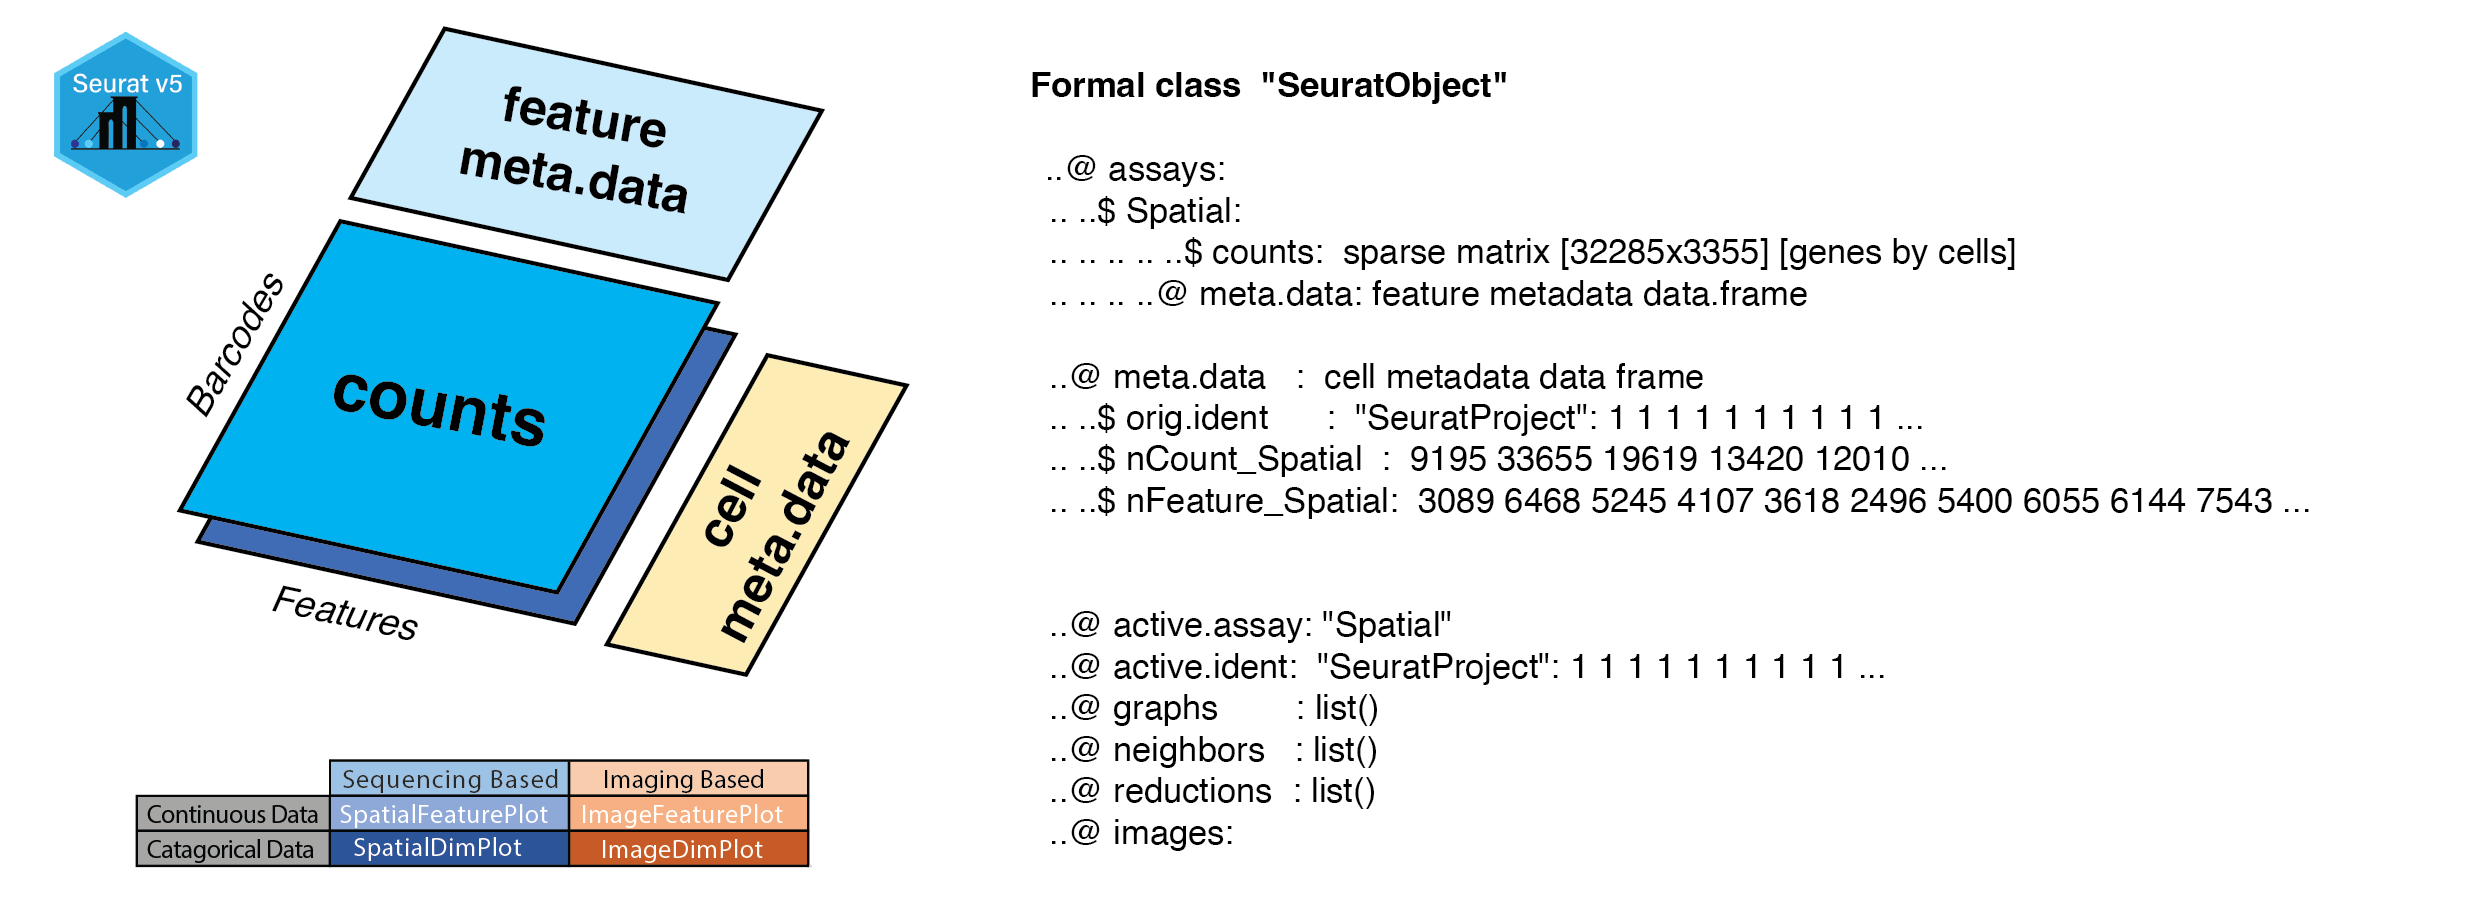


You can see in the first image the structure of an assay -> this involves multiple slots, containg data.frames/tables that store different types of data such as raw gene expression counts ('counts'), gene meta.data ("feature meta.data), and has the ability to add additional slots such as normalised and scaled expression counts ('data' and 'scaled.data' respectively -> dark blue box). 

A more detailed structure is depected on the left which explains all the different slots and storage buckets involved in a seurat object. This will come in handy for later/down stream analyses. 

Finally, the table displays the different nomenclature used when plotting image or sequence based data, along with also the type of data being plotted. For example if we are plotting gene expression this is a continous value compared to cluster/cell type labels which are catagorical data.


<br>

Lets use *Seurat* to plot the Visium and Xenium Data

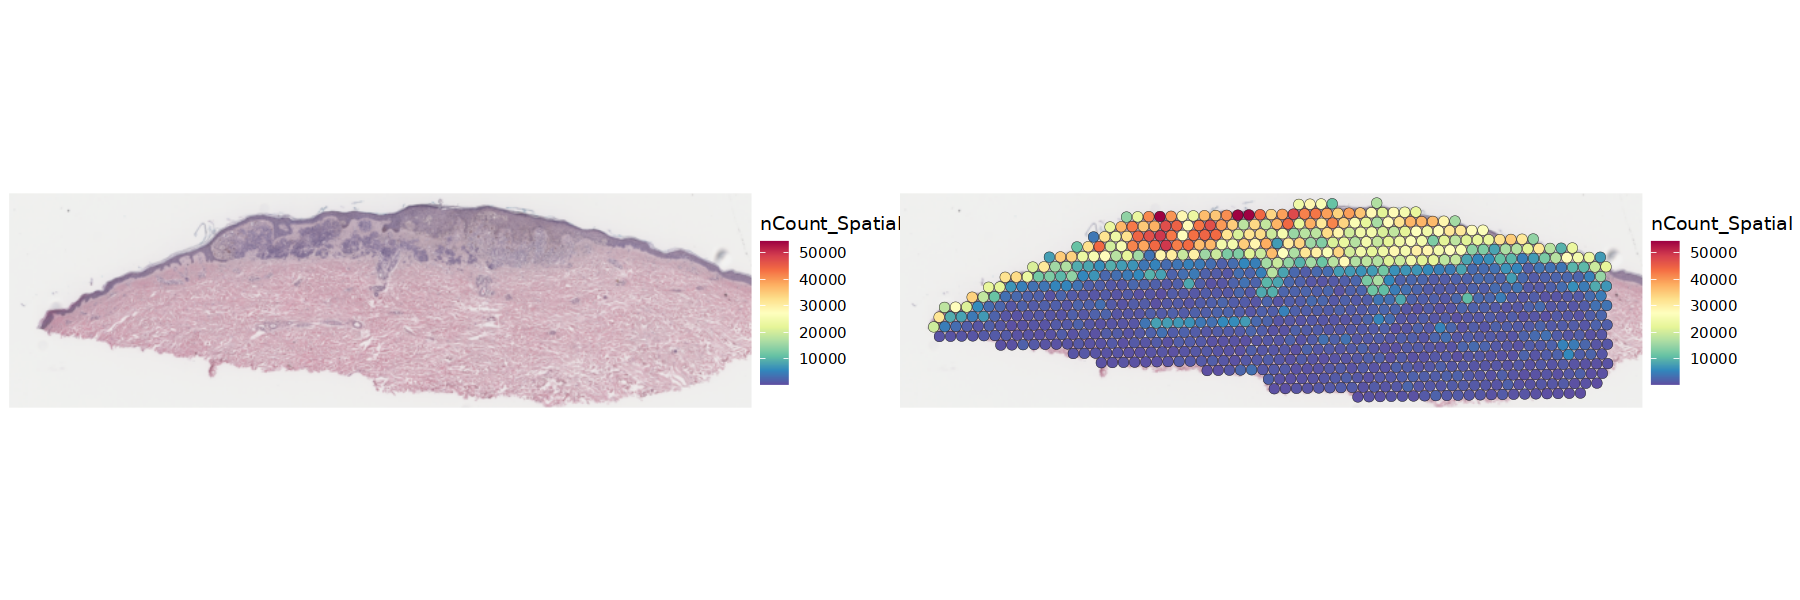

In [127]:
options(repr.plot.width = 15, repr.plot.height = 5) #helps us change the view size of plots in this notebook

SpatialFeaturePlot(visium, features = "nCount_Spatial", pt.size.factor = 1.2, alpha = 0) + theme_void() | SpatialFeaturePlot(visium, features = "nCount_Spatial", pt.size.factor = 1.2) + theme_void()

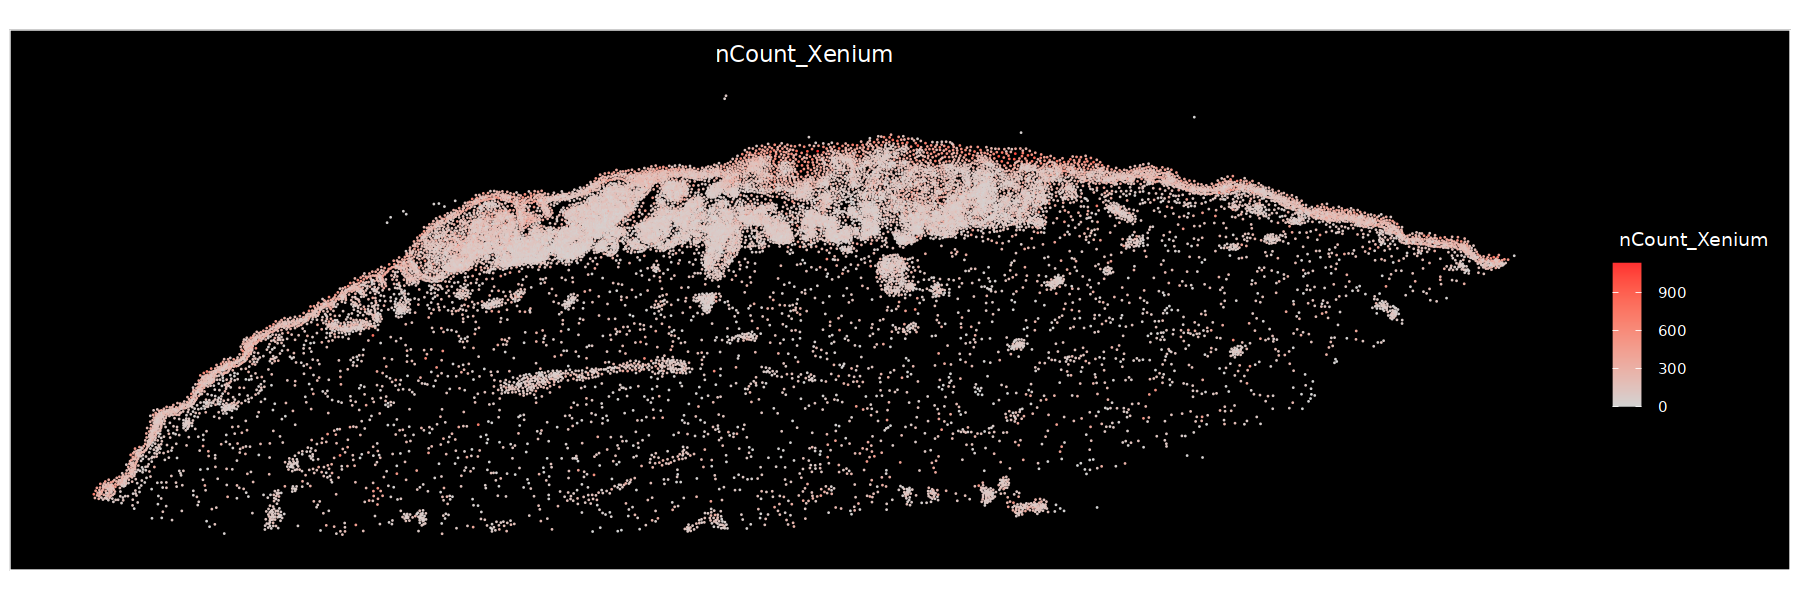

In [128]:
ImageFeaturePlot(xenium, features = "nCount_Xenium", dark.background = T)

The plots above are showing 'nCounts' which is the total number of reads present in each spot or cell. 

The major difference between Visium vs Xenium data is the trade off between cellular resolution vs sequencing depth. 
* Visium data has a very high sequencing depth allowing us to access ~18,000 genes across every 'spot'. However, each 'spot' is a combination of ~2-10 cells.
* Xenium data is at single cell resolution, meaning we have expression values for every single cell. However, we only have access to ~300 genes which are chosen based on the relative 10X imaging pannel used

Due to these limitations of both technologies it is useful to analyses them together as they complement eachother. 

#### Seurat Object Structure

Lets look at the data slots for both our Visium and Xenium Objects

In [129]:
cat("Visium Object ... ")
visium

cat("\nXenium Object ... ")
xenium

Visium Object ... 

An object of class Seurat 
18085 features across 923 samples within 1 assay 
Active assay: Spatial (18085 features, 0 variable features)
 1 layer present: counts
 1 image present: slice1


Xenium Object ... 

An object of class Seurat 
541 features across 21596 samples within 4 assays 
Active assay: Xenium (260 features, 0 variable features)
 1 layer present: counts
 3 other assays present: BlankCodeword, ControlCodeword, ControlProbe
 1 spatial field of view present: fov

Based on this readable output we can see the number of features and genes that our Visium and Xenium Data has:

|  Data Type  | #Spots/Cells       |     #Genes     |
| :----:      |     :----:              |  :----:       |
| Visium      | 923   | 18,085 |
| Xenium      | 21,596 |  260  |

we can also see some other key information: 

|  Data Type  | Active Assay Name       |     Present Assay Layers   | Spatial Data Location |
| :----:      |     :----:              |  :----:       | :----:|
| Visium      | "Spatial"  | "counts" | image: 'slice1'|
| Xenium      | "Xenium" |  "counts" | field of view (fov): 'fov'|

<br>

This information is important because it tells us how to access the correct slot where our data of interest is stored (i.e. raw gene expression matrix, sample metadata, image cooridnates)

Lets look at our gene expression first -> this is stored in the $counts slot within the deafault assay (Visium defaultAssay = "Spatial", Xenium defaultAssay = "Xenium") 

In [130]:
## lets look at the first 10 rows and columns of each counts mtx

cat ("Visium counts matrix")
visium@assays$Spatial$counts[1:10, 1:10]

cat ("\nXenium counts matrix")
xenium@assays$Xenium$counts[1:10, 1:10]

Visium counts matrix

  [[ suppressing 10 column names ‘AACACGTGCATCGCAC-1’, ‘AACAGGAAGAGCATAG-1’, ‘AACATCTAATGACCGG-1’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                             
SAMD11   . . . .  . . . . . .
NOC2L    . . . .  1 . . 1 . .
KLHL17   . . . .  . . . . 1 .
PLEKHN1  . . . .  8 . . . . .
PERM1    . . . .  . . . . . .
HES4     . . . 1  6 . . . 1 .
ISG15    . . . .  . . . . . .
AGRN     . . . 1 19 2 . . . 1
RNF223   . . . .  . . . . . .
C1orf159 . . . .  2 . . 1 . .


Xenium counts matrix

  [[ suppressing 10 column names ‘aaaanabd-1’, ‘aaagncnp-1’, ‘aaahjphg-1’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                               
ACER1   . . . .  .  .  . .  . .
ACTA2   . . . .  .  .  . .  . .
ADAM12  . . . .  .  .  . .  . .
AHNAK2  . . . .  .  .  1 .  . .
AIF1    . . . .  2  1  . 1  2 .
AKR1C1  . . . .  .  .  . .  1 .
ALOX5AP . . . .  .  .  . .  . .
APCDD1  . . . . 21 13 11 4 18 7
APOD    . . . .  2  3  5 1  1 2
AQP1    . . . .  2  2 23 2 16 3

We can see that we have our gene names as rows and our cell/spots are columns. We can also see that the values are integers so the data has not been normalised yet (these are raw counts). Lets look at the metadata now!

In [131]:
## Lets look at the @meta.data slot now. This is where metadata for each cell/spot is stored
## lets look at the first 6 rows

cat ("Visium meta.data table")
head(visium@meta.data)

cat ("Xenium meta.data table")
head(xenium@meta.data)

Visium meta.data table

orig.ident    nCount_Spatial nFeature_Spatial
AACACGTGCATCGCAC-1 SeuratProject   980           717            
AACAGGAAGAGCATAG-1 SeuratProject  1003           715            
AACATCTAATGACCGG-1 SeuratProject  1466          1005            
AACATGCGCAAGTGAG-1 SeuratProject  2356          1688            
AACCAGAATCAGACGT-1 SeuratProject 44942          8952            
AACCATCGGAAGCGAC-1 SeuratProject  4309          2807

Xenium meta.data table

orig.ident    nCount_Xenium nFeature_Xenium nCount_BlankCodeword
aaaanabd-1 SeuratProject   5            4              0                   
aaagncnp-1 SeuratProject   8            7              0                   
aaahjphg-1 SeuratProject   2            2              0                   
aaaipkle-1 SeuratProject   2            2              0                   
aaajabff-1 SeuratProject 252           61              0                   
aaajjcmo-1 SeuratProject 188           56              0                   
           nFeature_BlankCodeword nCount_ControlCodeword
aaaanabd-1 0                      0                     
aaagncnp-1 0                      0                     
aaahjphg-1 0                      0                     
aaaipkle-1 0                      0                     
aaajabff-1 0                      0                     
aaajjcmo-1 0                      0                     
           nFeature_ControlCodeword nCount_ControlProbe nFeature_ControlProbe
aaaanabd-1 0                        0                   0                    
aaagncnp-1 0                        0                   0                    
aaahjphg-1 0                        0                   0                    
aaaipkle-1 0                        0                   0                    
aaajabff-1 0                        0                   0                    
aaajjcmo-1 0                        0                   0

We can see that for Visium data we have barodes as the rownames which represent the barcode sequence. Whereas for xenium data, each cell has a unique name represented by this code. In addition, the @meta.data slot stores important information including the number of reads (nCount_Spatial/nCount_Xenium) and the number of genes (nFeature_Spatial/nFeature_Xenium) within each spot/cell


Now that we have loaded in our data we will perform some general

#### Visium Pre-Processing

First we will process our Visium data. Visium data is mainly susceptible to sequencing based technical noise, meaning that sequening depth across data points, between different arrays can varry. To control for this we implement two main steps:

1. Removing outlying data spots and genes
2. Normalising for sequencing depth difference between spots


*Removing outlying data spots and Genes*
* Generally we consider a spot as an outlyer if its counts diverge from the general distribution of the dataset as a whole. In otherwords, If a spot has excessively high or low number of total reads compared to all other spots we will remove it.
* In addition, spots can be considered outlyers if they have excessively high levels of mitochondrial content, as this suggests the cells could be dead/dying cells. NOTE: Some diseases (such as cancer) have high levels of MT reads so it is important to check, before setting a threshold to filter out spots. 
* Similarly, genes are removed if they are rarely expressed. As a general rule of thumb, we assume a gene must be expressed in atleast 3 cells to be classified as a valid gene. This threshold is rather abitrary, but is based of lack of statistical power when performing differential gene expression analysis

To determine the best thresholds to use for our dataset, we can use some general plots to visualise the distribution of total reads, genes and percentage of mitochondrial genes per spot.

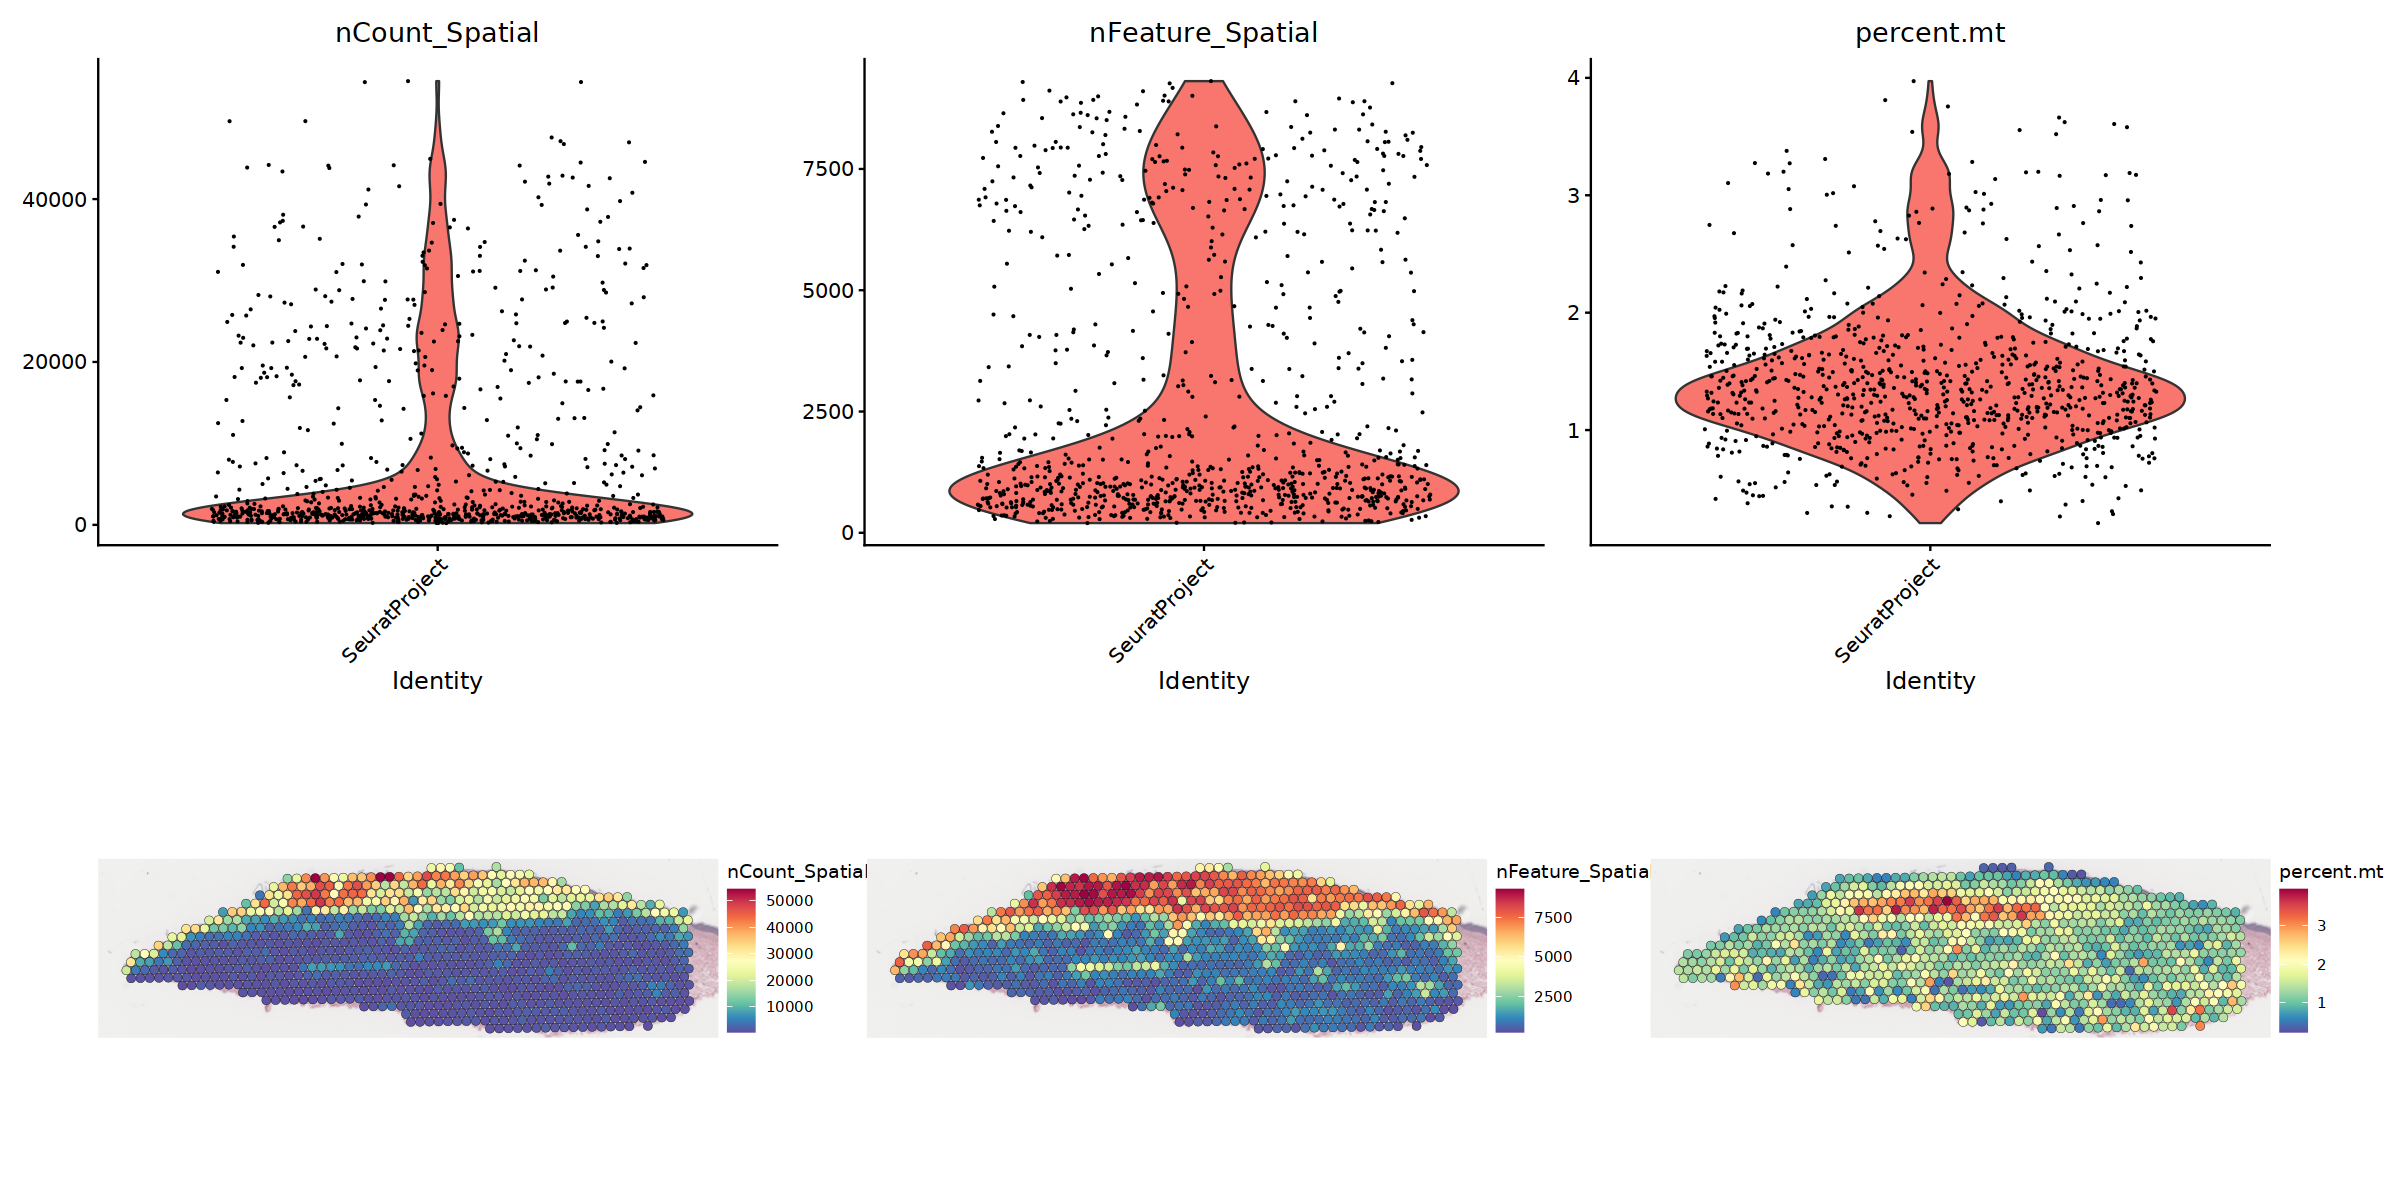

In [137]:
# Quantifies the percentage of mt genes per spot
visium@meta.data$percent.mt <- PercentageFeatureSet(visium, pattern = "^MT-")

# Plot vln plots 
vlnplots <- VlnPlot(visium, features = c("nCount_Spatial","nFeature_Spatial", "percent.mt"), layer = "counts", pt.size = 0.1) & NoLegend()
sptplots <- SpatialFeaturePlot(visium, features = c("nCount_Spatial","nFeature_Spatial", "percent.mt"), pt.size.factor = 1.2) & theme_void() & theme(legend.position = "right") # "& theme()" is a way of changing the plot layout seetings to improve visualisation

# Visualise plots
options(repr.plot.width = 20, repr.plot.height = 10)

vlnplots/sptplots

We can see that the majority of spots have ~ 10,000 counts and 2,500 genes. We can also see that this sample has a maxium of 4% MT content which is not abnormal. A common threshold to use is often ~20% but will change depending on the sample. 

Now we can filter our data and see which spots have been removed, we will also filter lowly observed genes too. 

In [134]:
# Remove outlyer spots 
visium <- subset(visium, subset = nCount_Spatial > 200)

# Remove lowly observed genes
selected_genes <- rownames(visium)[Matrix::rowSums(visium@assays$Spatial$counts > 0) >= 3] # gets list of genes that are expressed in atleast 3 cells/spots

visium <- subset(visium, features = selected_genes)

Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Seurat objects”


We can now visualised the QC results

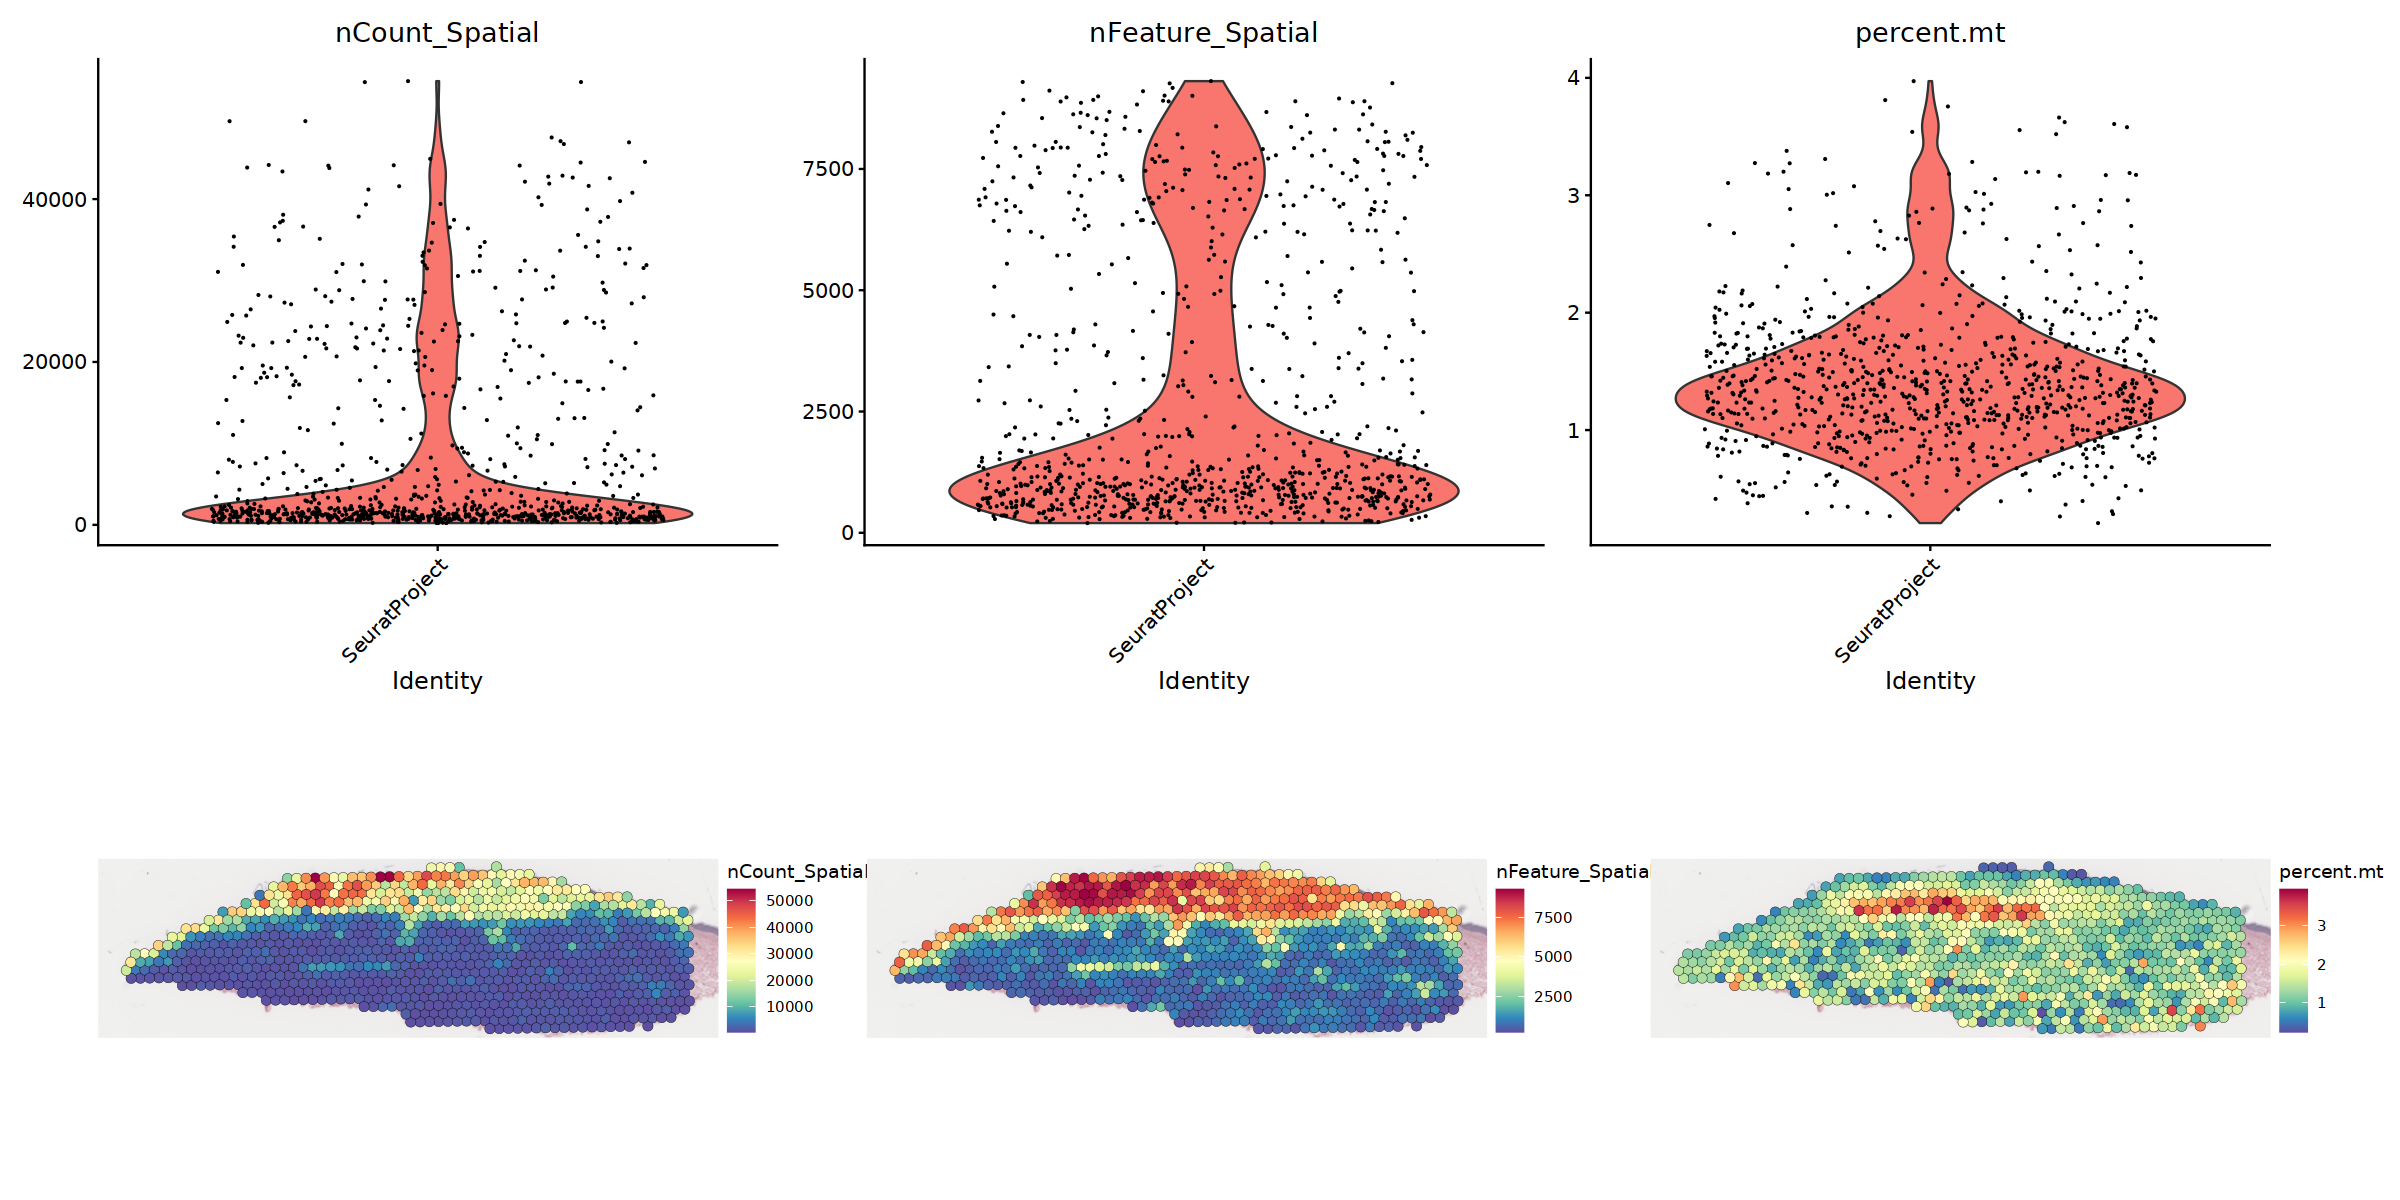

In [135]:
# Plot vln plots 
vlnplots <- VlnPlot(visium, features = c("nCount_Spatial","nFeature_Spatial",  "percent.mt"), layer = "counts", pt.size = 0.1) & NoLegend()
sptplots <- SpatialFeaturePlot(visium, features = c("nCount_Spatial","nFeature_Spatial",  "percent.mt"), pt.size.factor = 1.4) & theme_void() &theme(legend.position = "right")

# Visualise plots
options(repr.plot.width = 20, repr.plot.height = 10)

vlnplots/sptplots

In [136]:
visium

An object of class Seurat 
15155 features across 917 samples within 1 assay 
Active assay: Spatial (15155 features, 0 variable features)
 1 layer present: counts
 1 image present: slice1

We can see that we now have ~15,000 genes instead of ~18,000; and 6 spots were removed, now having 917 compared to 923. 

The next step is normalisation:

#### Normalising Visium Data

Normalisation is an import process that allows us to control for differences in sequencing depth across a sample. Similar to traditional single-cell approachs normalisation is required to ensure gene expression values are not skewed when calculating genes that are differentially expressed between different groups of spots/cells.

The classical way of normalising scRNA and also Spatial data was to use a technique called library size normalisaion (read here for more info: https://bioconductor.org/books/3.17/OSCA.basic/normalization.html). The aim is to scale the data by a "library size factor" which results in each spot being directly proportional to the library size of each spot. For example: if the expression of GeneA is 10 in one spot and the library size of that spot is 20, compared to another spot where the expression of the GeneA is 10 but the library size is 1000, then the normalised expression level of GeneA is spot 2 would be much lower then the normalised expression level of GeneA in spot 1. This however has some limitations, as this approach assumes that all spots/cells should have the same sequencing depth/library size. This would not be true though if we were comparing tumour cells which have a high level of gene expression by nature compared to an adipocytes which has relatively low number of genes expressed comparably. 


The alternative approach is to use a method such as *SCTransfrom*. SCTransform is a more advanced method that provides normalization, variance stabilization, and batch effect correction in one step using a regularized negative binomial regression model. This function works by:
* Modeling Counts: Fits a generalized linear model (GLM) to each gene's counts using a negative binomial distribution.
* Variance Stabilization: Estimates the mean-variance relationship and transforms the data to stabilize variance across genes. This transformation adjusts the data such that the variance becomes approximately constant across the mean expression levels. This is important as genes with higher mean expression levels tend to have higher variance (this many not be biological though), so when trying to identify differentially expressed genes, withough variance stabilisation it would be hard to tell if the variance within a gene is technical or biological. The relationship between the mean and the variance is then modelled for a more accurate estimation of biological variability. 
* Normalization: Adjusts for differences in sequencing depth and other technical factors.

If you would like to read more about the underlying mathamatics and statistics behind this function see here: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1 
                                                                                                                      
SCTransfrom tends to be the most common and suitable approach for normalisation Spatial Data, so we will implement that function below                                                                                                                      
                                                                                                                                                                                                                

In [138]:
visium <- SCTransform(visium, assay = "Spatial", verbose = TRUE) # if you dont want to see the function messages printed below set verbose = FALSE

Running SCTransform on assay: Spatial

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 14603 by 917

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 917 cells

Found 172 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 14603 genes

Computing corrected count matrix for 14603 genes

Calculating gene attributes

Wall clock passed: Time difference of 6.919735 secs

Determine variable features

Centering data matrix

Set default assay to SCT



In [139]:
visium

An object of class Seurat 
29758 features across 917 samples within 2 assays 
Active assay: SCT (14603 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: Spatial
 1 image present: slice1

We can now see that our data object has been normalisated and a new assay has been created to store the normalised expression values. This assay is called "SCT", which contains 3 slots -> counts, data and scale.data

<br>

|  Data Slot  | Definition      |
| :----:      |     :----:      |
| counts      | stores the raw gene expression counts after normalisation but before transformation (integers) | 
| data      | stores the transformed gene expression data which have undergone normalisation, variance stabilisation, and scaling (This is the data we used for plotting/calculating DE genes)| 
| scale.data      | stores the pearson residuals from the regression model  | 

<br>

Let check how the data has changed between raw vs normalised

In [144]:
## lets look at the first 10 rows and columns of each counts mtx (raw vs normalised)

cat ("Raw counts matrix")
visium@assays$Spatial$counts[1:10, 1:10]

cat ("\nSCT counts matrix")
visium@assays$SCT$counts[1:10, 1:10]

cat ("\nSCT data matrix")
visium@assays$SCT$data[1:10, 3:5]

Raw counts matrix

  [[ suppressing 10 column names ‘AACACGTGCATCGCAC-1’, ‘AACAGGAAGAGCATAG-1’, ‘AACATCTAATGACCGG-1’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                             
SAMD11   . . . .  . . . . . .
NOC2L    . . . .  1 . . 1 . .
KLHL17   . . . .  . . . . 1 .
PLEKHN1  . . . .  8 . . . . .
PERM1    . . . .  . . . . . .
HES4     . . . 1  6 . . . 1 .
ISG15    . . . .  . . . . . .
AGRN     . . . 1 19 2 . . . 1
RNF223   . . . .  . . . . . .
C1orf159 . . . .  2 . . 1 . .


SCT counts matrix

  [[ suppressing 10 column names ‘AACACGTGCATCGCAC-1’, ‘AACAGGAAGAGCATAG-1’, ‘AACATCTAATGACCGG-1’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                            
SAMD11   . . . . . . . . . .
NOC2L    . . . . . . . 1 . .
KLHL17   . . . . . . . . . .
PLEKHN1  . . . . 1 . . . . .
PERM1    . . . . . . . . . .
HES4     . . . 1 1 . . . . .
ISG15    . . . . . . . . . .
AGRN     . . . 1 2 1 . . . 2
RNF223   . . . . . . . . . .
C1orf159 . . . . . . . 1 . .


SCT data matrix

10 x 3 sparse Matrix of class "dgCMatrix"
         AACATCTAATGACCGG-1 AACATGCGCAAGTGAG-1 AACCAGAATCAGACGT-1
SAMD11                    .          .                  .        
NOC2L                     .          .                  .        
KLHL17                    .          .                  .        
PLEKHN1                   .          .                  0.6931472
PERM1                     .          .                  .        
HES4                      .          0.6931472          0.6931472
ISG15                     .          .                  .        
AGRN                      .          0.6931472          1.0986123
RNF223                    .          .                  .        
C1orf159                  .          .                  .        

We can see here how each of the matricies differs. Compared to our raw counts, the SCT $counts slot has our adjusted counts based on the sequencing depth. Whereas the data slot has the transformed values after normalisation (using the SCTransform model) has been completed.


When running SCTransform 3000 variable features are calculated -> these represent the top 3000 most highly variable genes expressed across cells. These genes are often the most informative for definning different cell types. These will be useful in the next step, but for now we can plot them to see what the top 10 features are. 

When using repel, set xnudge and ynudge to 0 for optimal results



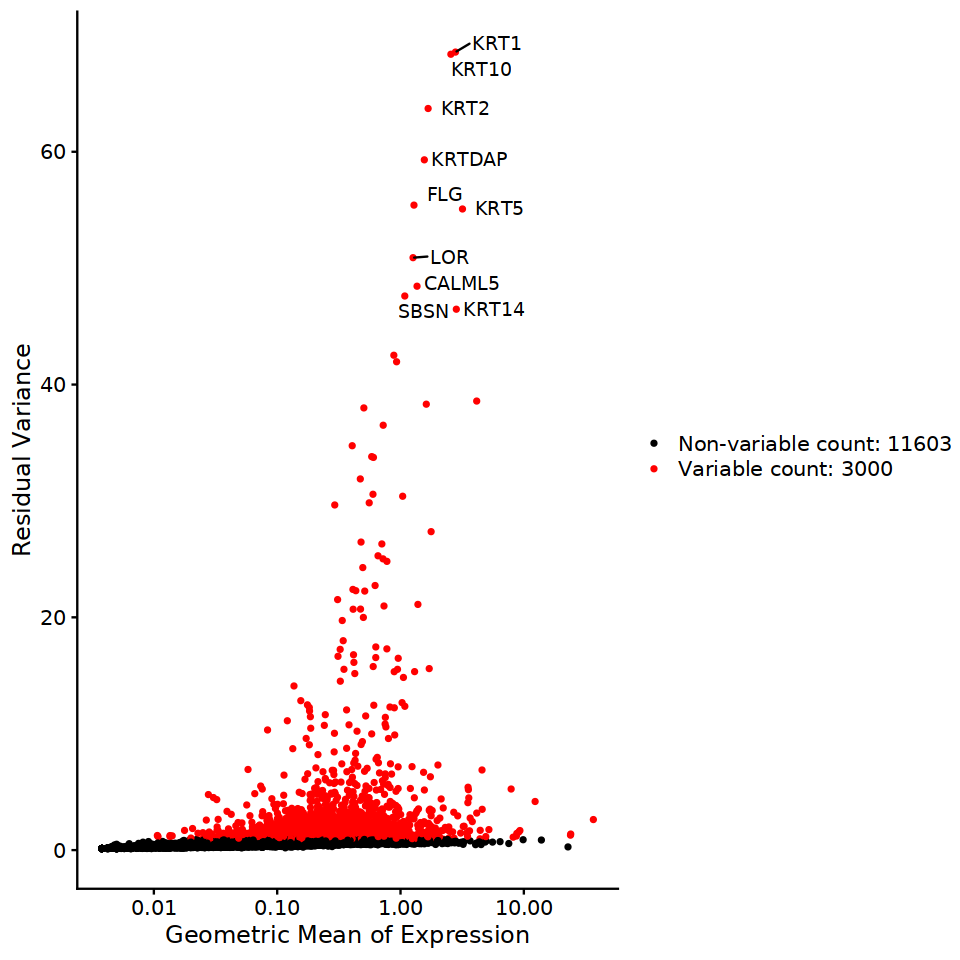

In [145]:
options(repr.plot.width = 8, repr.plot.height = 8)

plot1 <- VariableFeaturePlot(visium)
LabelPoints(plot = plot1, points = head(VariableFeatures(visium), 10), repel = TRUE)

We can see one of the top varible genes is KRT1. Lets look at this feature spatially along with another gene thats not in our top variable feature list like HES4, and see how they differ before/after normalisation

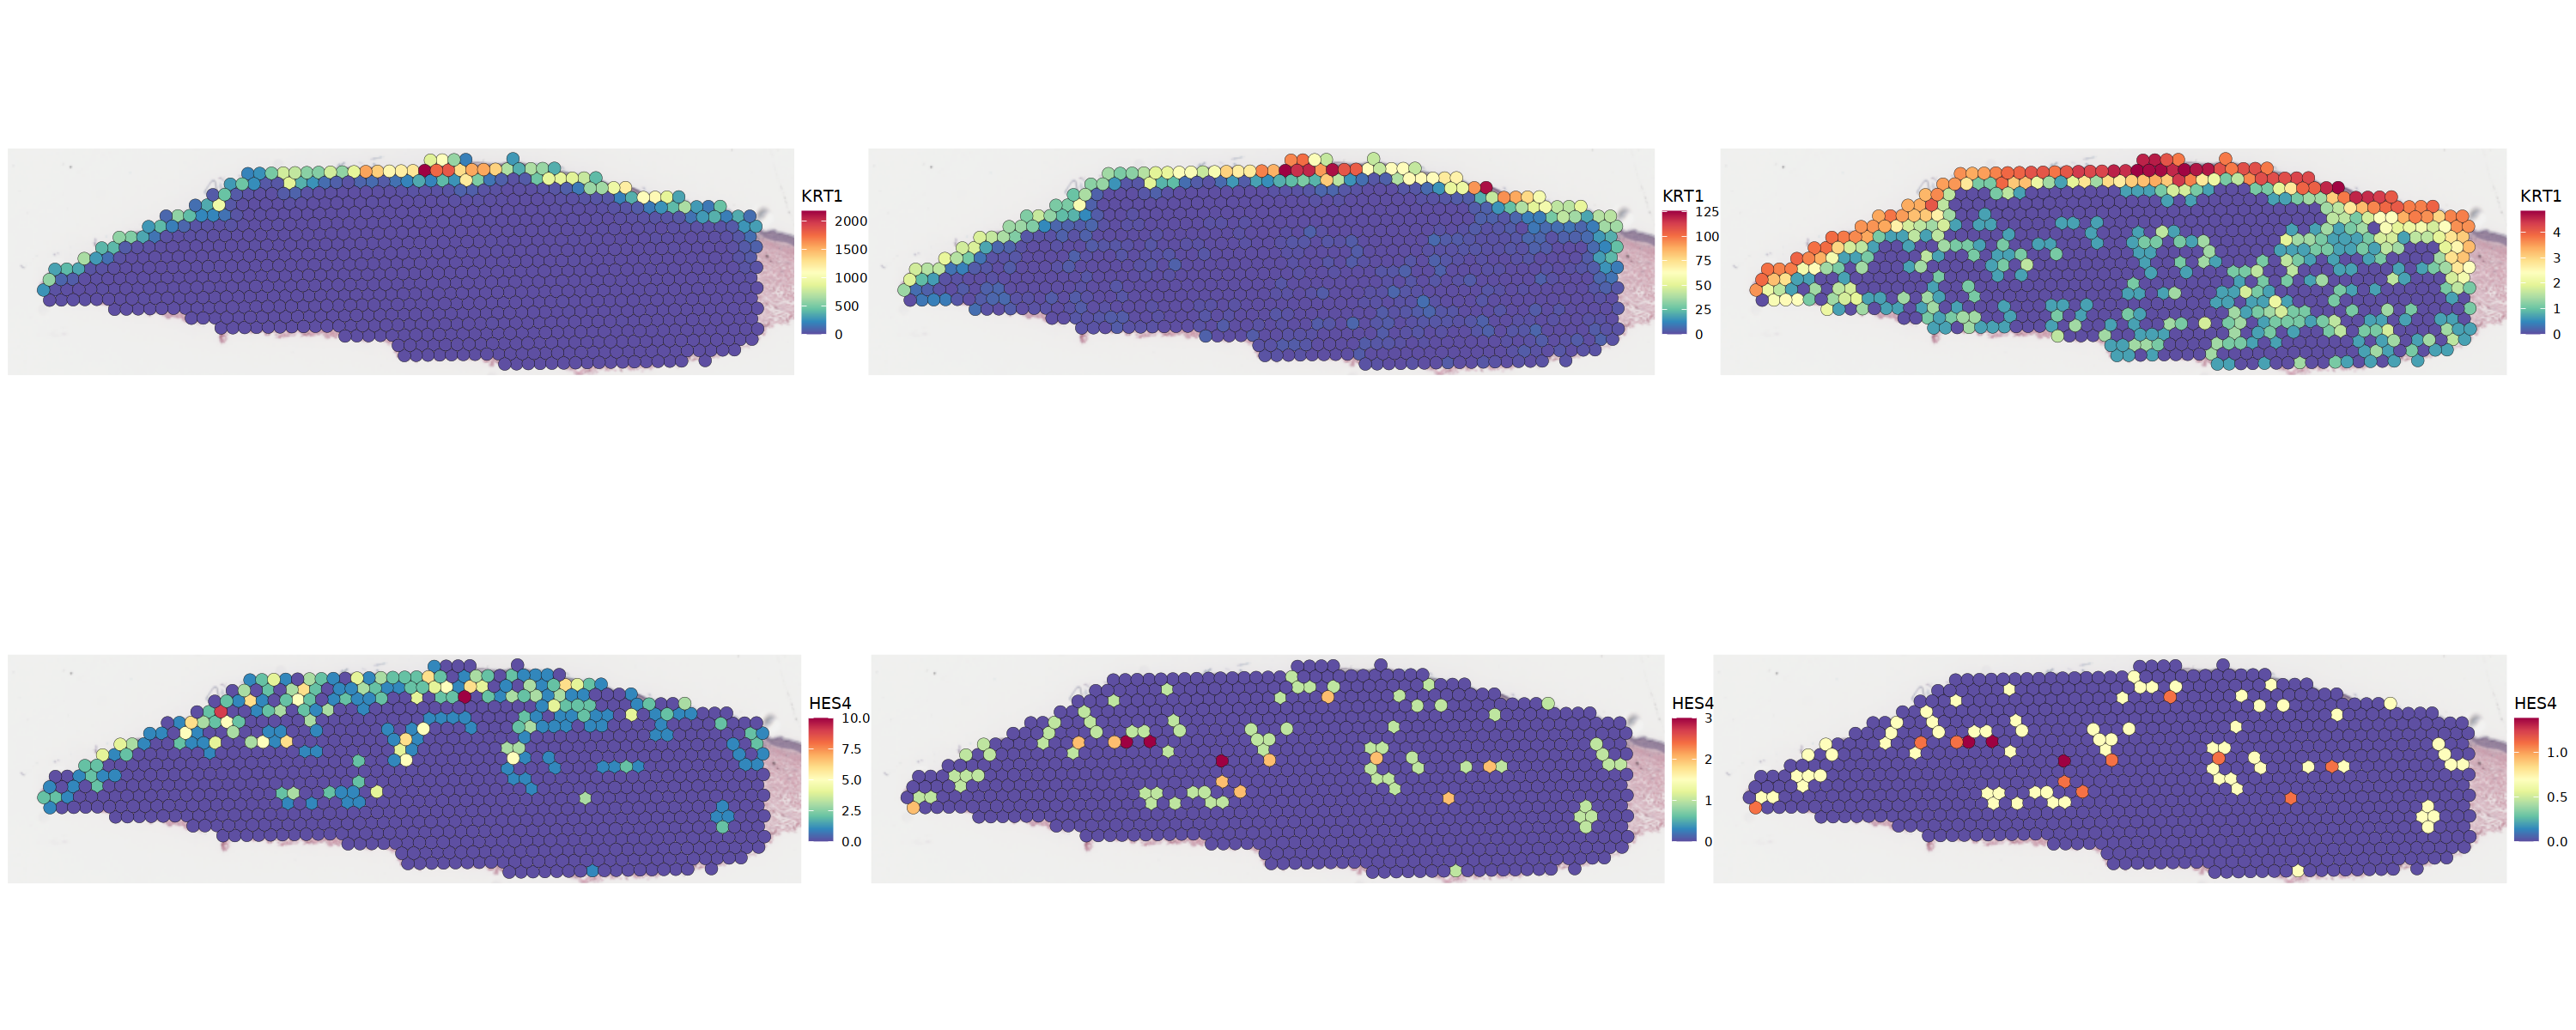

In [151]:
DefaultAssay(visium) <- "Spatial" #This is how we select what assay we want to use

raw_count_plot_DCD <- SpatialFeaturePlot(visium, features = "KRT1", slot = "counts", pt.size.factor = 1.4) + theme_void()
raw_count_plot_HES4 <- SpatialFeaturePlot(visium, features = "HES4", slot = "counts", pt.size.factor = 1.4) + theme_void()

DefaultAssay(visium) <- "SCT" 
sct_count_plot_DCD <- SpatialFeaturePlot(visium, features = "KRT1", slot = "counts", pt.size.factor = 1.4) + theme_void()
sct_data_plot_DCD <- SpatialFeaturePlot(visium, features = "KRT1", slot = "data", pt.size.factor = 1.4) + theme_void()

sct_count_plot_HES4 <- SpatialFeaturePlot(visium, features = "HES4", slot = "counts", pt.size.factor = 1.4) + theme_void()
sct_data_plot_HES4 <- SpatialFeaturePlot(visium, features = "HES4", slot = "data", pt.size.factor = 1.4) + theme_void()

# print plots
options(repr.plot.width = 25, repr.plot.height = 10)

(raw_count_plot_DCD |sct_count_plot_DCD|sct_data_plot_DCD)/
(raw_count_plot_HES4 |sct_count_plot_HES4|sct_data_plot_HES4)

Here we can see that for our top variable gene "KRT1" after normalisation the expression pattern is quite similar to the raw data, highlighting that SCT transformation has maintained the biological variance of this gene. Alternatively, for our non-variable feature we can see the raw expression show a pattern along the epidermis, which is not present as much in the normalised data. This is because the epidermis has a high proportion of genes compared to the subcutaneous layers which have much lower levels. Meaning that in the raw data although this gene look relatively highly    

#### Xenium Pre-Processing

Xenium Pre-Processing is slightly different to Visium data, because count dat is generated using an imaging-based method. Because Xenium is also single cell resolution it means that the number of transcripts within a cell are quite accurate, but because we only have a few genes (~500) the number of counts/genes within each cell is much lower. But we can still implment similar functions used in the Visium preprocessing to perform QC on our Xenium data. 

First we will remove all cells that have 0 counts within them. 

Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Seurat objects”


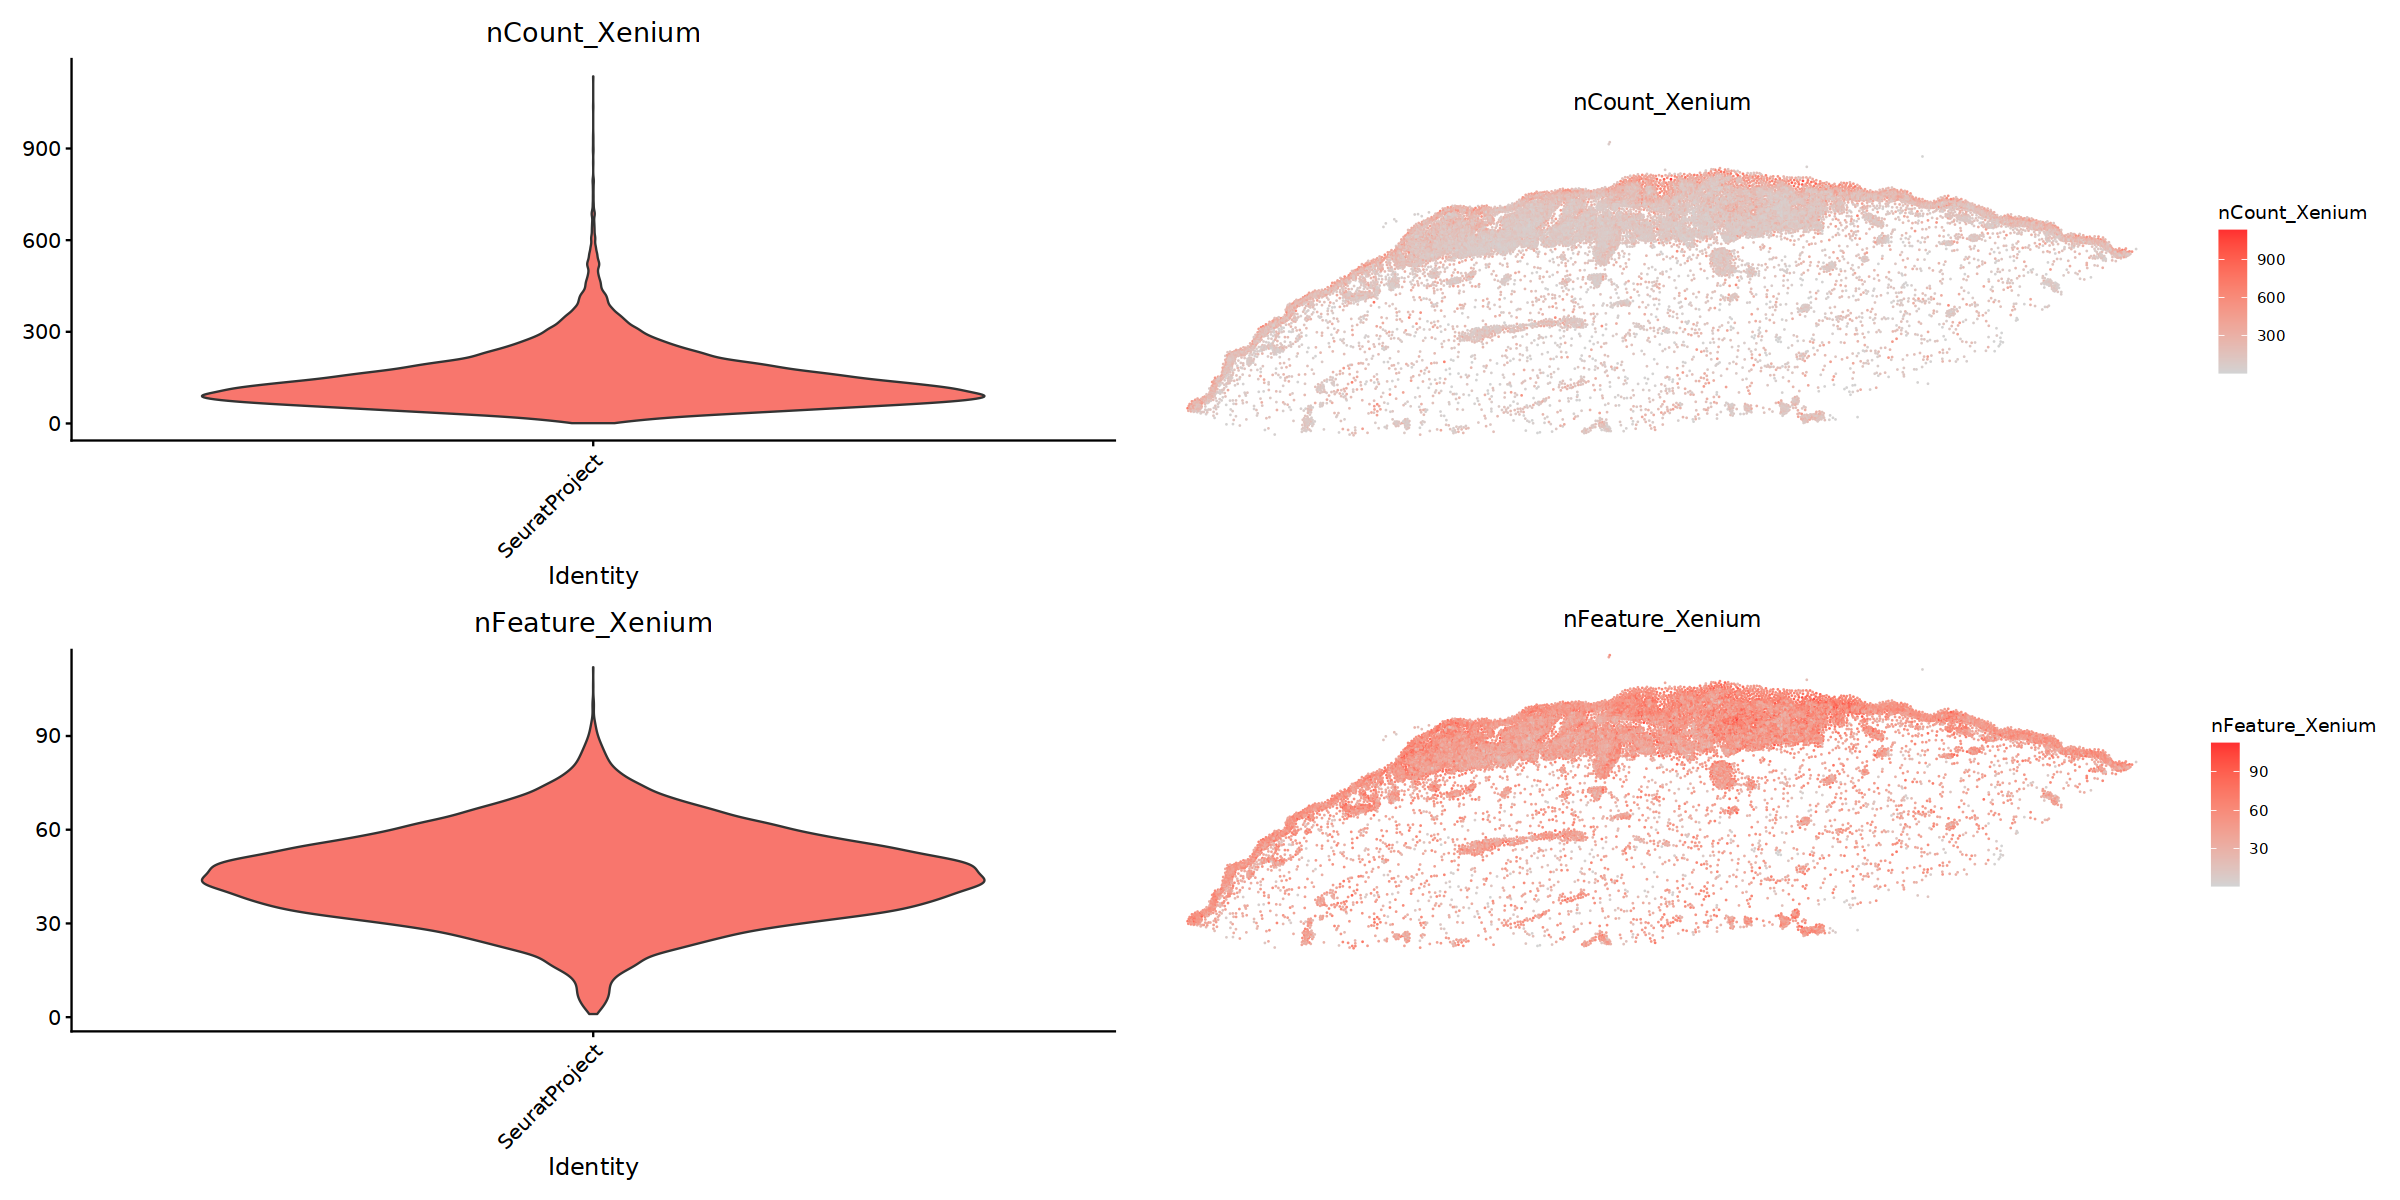

In [153]:
options(repr.plot.width = 20, repr.plot.height = 10)

# remove cells with 0 counts
xenium <- subset(xenium, subset = nCount_Xenium > 0)

# Plot vln plots 
vlnplots <- VlnPlot(xenium, features = c("nCount_Xenium","nFeature_Xenium"), layer = "counts", pt.size = 0, ncol = 1) & NoLegend()
sptplots1 <- ImageFeaturePlot(xenium, features = c("nCount_Xenium"), dark.background = F) & theme(legend.position = "right")
sptplots2 <- ImageFeaturePlot(xenium, features = c("nFeature_Xenium"), dark.background = F) & theme(legend.position = "right")

# Visualise plots
options(repr.plot.width = 20, repr.plot.height = 10)

vlnplots|(sptplots1/sptplots2)

Because this is Xenium data and there are only a few genes selected in the run panel, the number of genes expected in each cell is much lower and can even be 1. Also because the genes used in the panel are highly tested by 10X for cell typing, and there are a large number of cells, it is unlikely that we will observe any lowly observed genes. This means that filtering xenium data based on these parameters is not overly necessary, however the code below shows you how to implment them. 

In [ ]:
## Run if you want to remove cells and genes from xenium data
# Remove outlyer spots 
#xenium <- subset(xenium, subset = nCount_Xenium > 1)

# Remove lowly observed genes
#selected_genes <- rownames(xenium_sub)[Matrix::rowSums(xenium_sub@assays$Xenium$counts > 0) >= 1] # gets list of genes that are expressed in atleast 3 cells/spots

#xenium_sub <- subset(xenium_sub, features = selected_genes)

#### Xenium Normalisation

Xenium normalisation is again similar to Visium normalisation. Lets run SCTransform

In [154]:
xenium <- SCTransform(xenium, assay = "Xenium", verbose = FALSE)

In [155]:
xenium

An object of class Seurat 
800 features across 21593 samples within 5 assays 
Active assay: SCT (259 features, 259 variable features)
 3 layers present: counts, data, scale.data
 4 other assays present: Xenium, BlankCodeword, ControlCodeword, ControlProbe
 1 spatial field of view present: fov

We can again see that our normalised data is stored in the SCT assay slot.

## 2. Clustering and Cell Typing

This section will cover how to cluster visium and xenium data. It will also demonstrate how to cell type these clusters once they have been generated. 


In [158]:
1

[1] 1

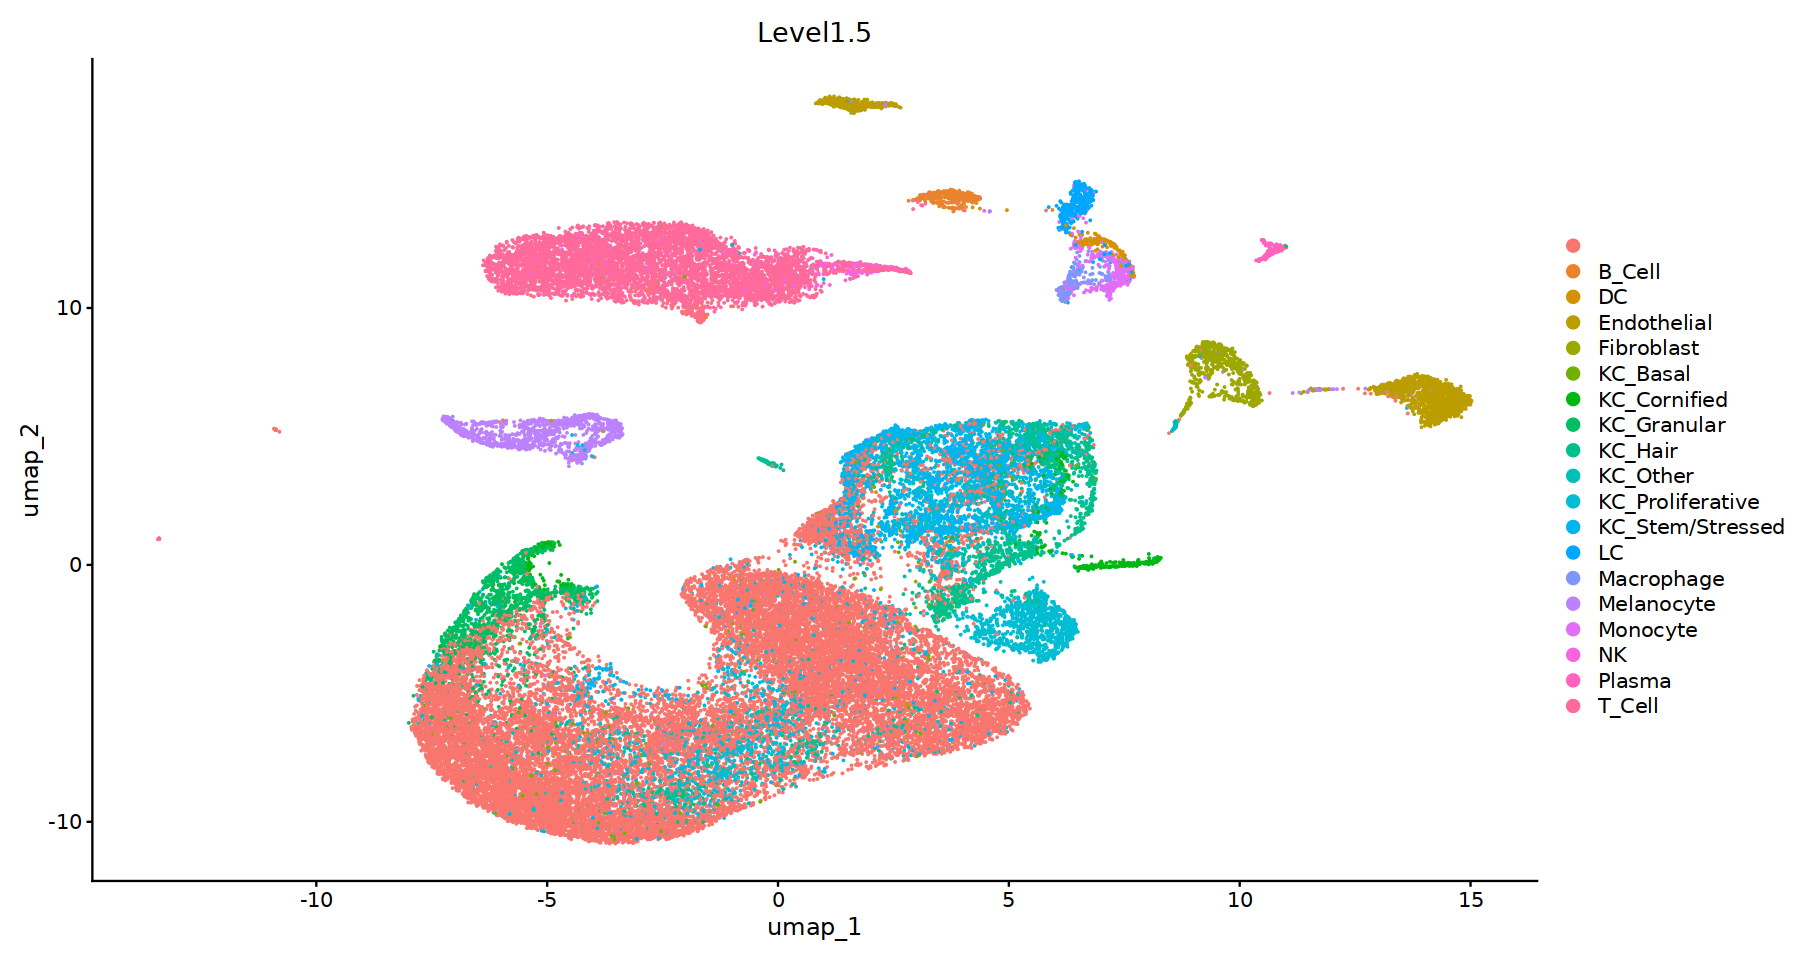

In [58]:
DimPlot(brain, group.by = "Level1.5")

In [51]:
brain <- SCTransform(scRNA)
brain <- RunPCA(brain, assay = "SCT", verbose = FALSE)
brain <- FindNeighbors(brain, reduction = "pca", dims = 1:30)
brain <- FindClusters(brain, verbose = FALSE)
brain <- RunUMAP(brain, reduction = "pca", dims = 1:30)
              

Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 21462 by 43403

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 538 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21462 genes

Computing corrected count matrix for 21462 genes

Calculating gene attributes

Wall clock passed: Time difference of 2.785015 mins

Determine variable features

Centering data matrix

Getting residuals for block 1(of 9) for counts dataset

Getting residuals for block 2(of 9) for counts dataset

Getting residuals for block 3(of 9) for counts dataset

Getting residuals for block 4(of 9) for counts dataset

Getting residuals for block 5(of 9) for counts dataset

Getting residuals for block 6(of 9) for counts da

In [48]:
scRNA <- readRDS("/QRISdata/Q2051/SCC_Paper/resources/data/allintegratedClustered_Seurat_JS_3.rds")

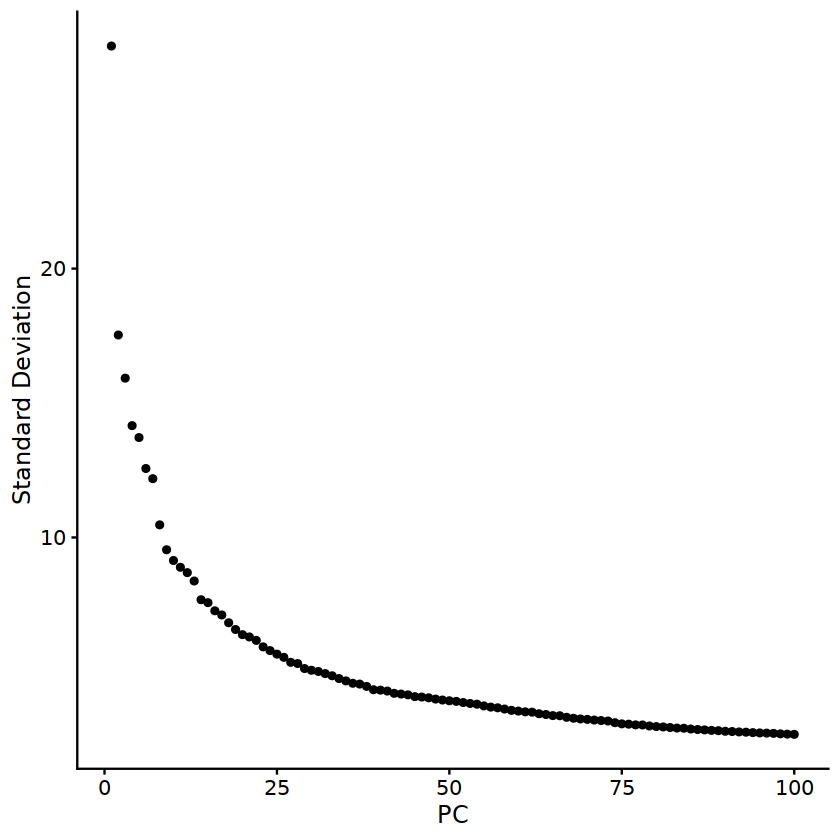

In [7]:
scRNA <- RunPCA(scRNA, verbose = F, npcs = 100)
ElbowPlot(scRNA, ndims = 100)

In [20]:
scRNA <- FindNeighbors(scRNA, dims = 1:20)
scRNA <- FindClusters(scRNA, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19811
Number of edges: 643401

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9421
Number of communities: 20
Elapsed time: 2 seconds


In [21]:
scRNA <- RunUMAP(scRNA, dims = 1:20)

09:57:39 UMAP embedding parameters a = 0.9922 b = 1.112

09:57:39 Read 19811 rows and found 20 numeric columns

09:57:39 Using Annoy for neighbor search, n_neighbors = 30

09:57:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:57:40 Writing NN index file to temp file /scratch/temp/9375832/RtmpDSICXH/file49ce22e9acc70

09:57:40 Searching Annoy index using 1 thread, search_k = 3000

09:57:45 Annoy recall = 100%

09:57:45 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

09:57:46 Initializing from normalized Laplacian + noise (using RSpectra)

09:57:48 Commencing optimization for 200 epochs, with 795250 positive edges

09:57:54 Optimization finished



In [24]:
scRNA <- RunTSNE(scRNA, dims = 1:20)

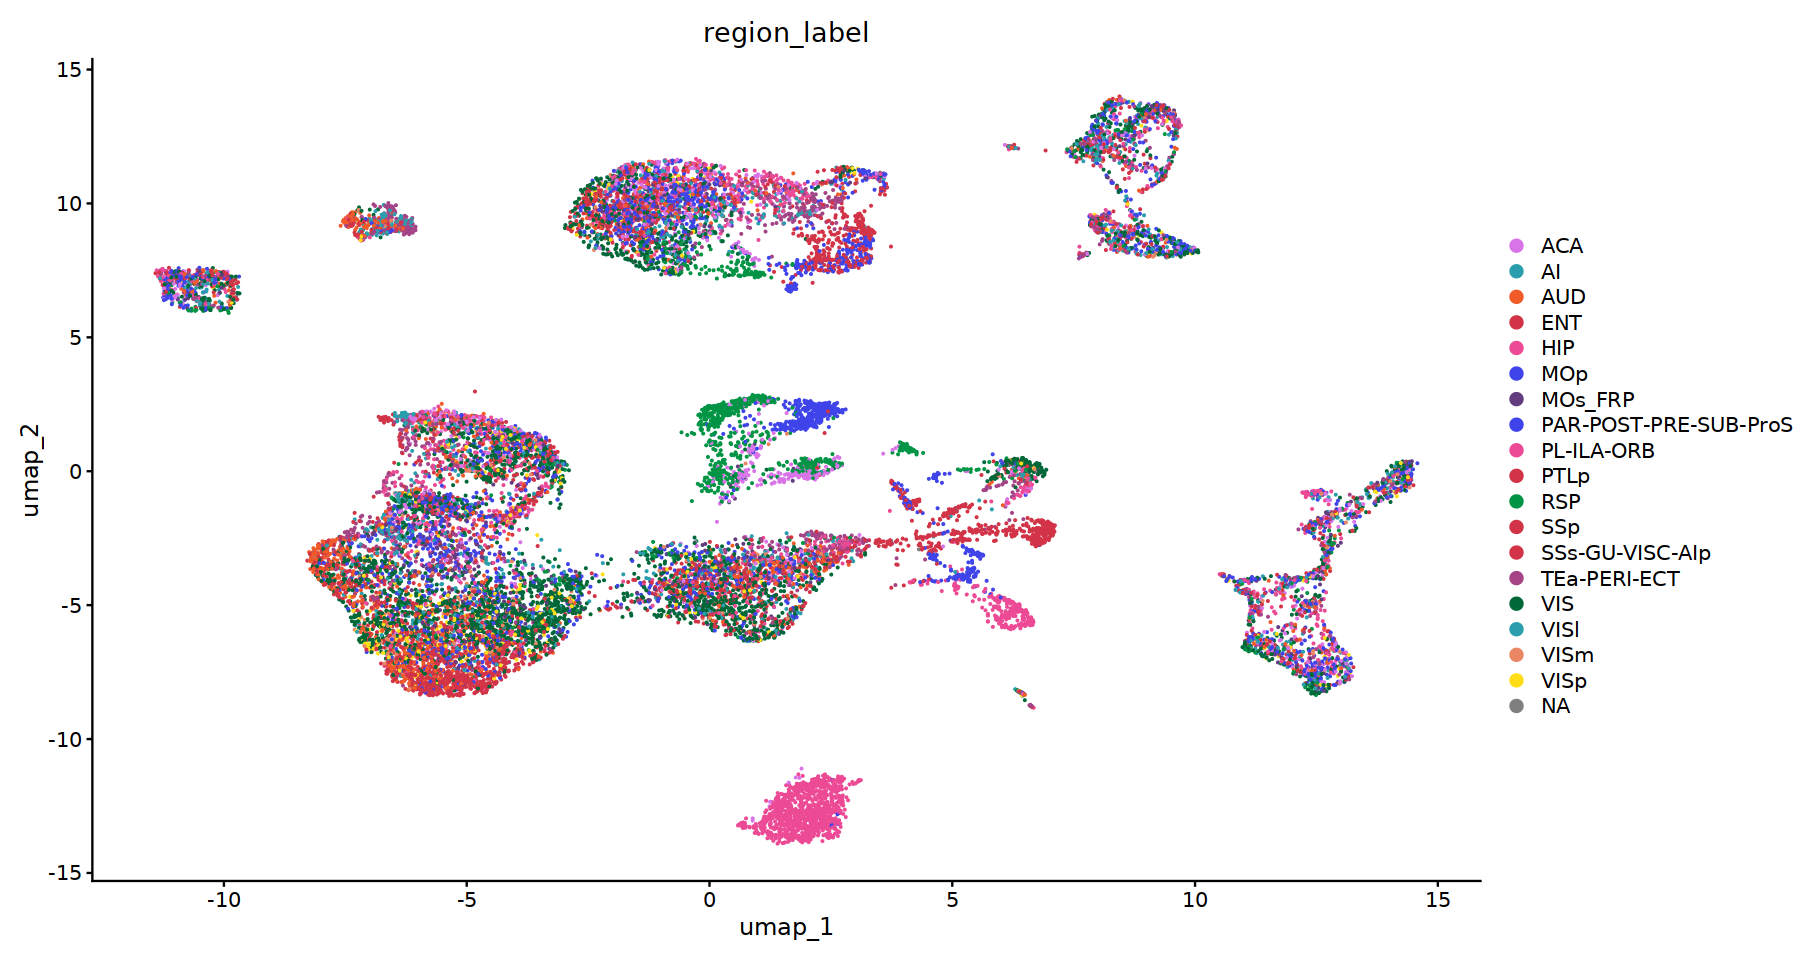

In [23]:
options(repr.plot.width = 15, repr.plot.height = 8)
DimPlot(scRNA, reduction = "umap", group.by = "region_label", cols = scRNA@meta.data$region_color) 

In [11]:
head(scRNA)

orig.ident    nCount_RNA nFeature_RNA
GGCTCGAGTTCGAATC-L8TX_180926_01_F01 SeuratProject 20073      5724        
CGCGTTTAGGATATAC-L8TX_180221_01_B11 SeuratProject  8025      3370        
ACCCACTTCTGGTGTA-L8TX_181206_01_H11 SeuratProject 22006      6001        
CGAATGTTCAAAGTAG-L8TX_171026_01_F04 SeuratProject 11449      4069        
AACGTTGTCCTCAACC-L8TX_180221_01_D10 SeuratProject 17051      5357        
TTTGGTTCAAGAGGCT-L8TX_180115_01_H10 SeuratProject 13448      4703        
ACGCCGAAGCAGACTG-L8TX_181012_01_B05 SeuratProject 11713      4456        
CGTGTCTCAACCGCCA-L8TX_180115_01_F10 SeuratProject  5617      2938        
TACTTGTAGGCATTGG-L8TX_180221_01_F10 SeuratProject 26430      6480        
CATTATCTCCCGGATG-L8TX_171026_01_F04 SeuratProject  8321      3600        
                                    sample_name                        
GGCTCGAGTTCGAATC-L8TX_180926_01_F01 GGCTCGAGTTCGAATC-L8TX_180926_01_F01
CGCGTTTAGGATATAC-L8TX_180221_01_B11 CGCGTTTAGGATATAC-L8TX_180221_01_B11
ACCCACTTCTGGTGTA-L8TX_181206_01_H11 ACCCACTTCTGGTGTA-L8TX_181206_01_H11
CGAATGTTCAAAGTAG-L8TX_171026_01_F04 CGAATGTTCAAAGTAG-L8TX_171026_01_F04
AACGTTGTCCTCAACC-L8TX_180221_01_D10 AACGTTGTCCTCAACC-L8TX_180221_01_D10
TTTGGTTCAAGAGGCT-L8TX_180115_01_H10 TTTGGTTCAAGAGGCT-L8TX_180115_01_H10
ACGCCGAAGCAGACTG-L8TX_181012_01_B05 ACGCCGAAGCAGACTG-L8TX_181012_01_B05
CGTGTCTCAACCGCCA-L8TX_180115_01_F10 CGTGTCTCAACCGCCA-L8TX_180115_01_F10
TACTTGTAGGCATTGG-L8TX_180221_01_F10 TACTTGTAGGCATTGG-L8TX_180221_01_F10
CATTATCTCCCGGATG-L8TX_171026_01_F04 CATTATCTCCCGGATG-L8TX_171026_01_F04
                                    donor_sex_id donor_sex_label
GGCTCGAGTTCGAATC-L8TX_180926_01_F01 2            M              
CGCGTTTAGGATATAC-L8TX_180221_01_B11 2            M              
ACCCACTTCTGGTGTA-L8TX_181206_01_H11 2            M              
CGAATGTTCAAAGTAG-L8TX_171026_01_F04 2            M              
AACGTTGTCCTCAACC-L8TX_180221_01_D10 2            M              
TTTGGTTCAAGAGGCT-L8TX_180115_01_H10 2            M              
ACGCCGAAGCAGACTG-L8TX_181012_01_B05 2            M              
CGTGTCTCAACCGCCA-L8TX_180115_01_F10 2            M              
TACTTGTAGGCATTGG-L8TX_180221_01_F10 2            M              
CATTATCTCCCGGATG-L8TX_171026_01_F04 2            M              
                                    donor_sex_color region_id region_label   
GGCTCGAGTTCGAATC-L8TX_180926_01_F01 #ADC4C3          8        SSs-GU-VISC-AIp
CGCGTTTAGGATATAC-L8TX_180221_01_B11 #ADC4C3         20        RSP            
ACCCACTTCTGGTGTA-L8TX_181206_01_H11 #ADC4C3         13        MOs_FRP        
CGAATGTTCAAAGTAG-L8TX_171026_01_F04 #ADC4C3         11        MOp            
AACGTTGTCCTCAACC-L8TX_180221_01_D10 #ADC4C3         15        PL-ILA-ORB     
TTTGGTTCAAGAGGCT-L8TX_180115_01_H10 #ADC4C3          2        VIS            
ACGCCGAAGCAGACTG-L8TX_181012_01_B05 #ADC4C3          5        PTLp           
CGTGTCTCAACCGCCA-L8TX_180115_01_F10 #ADC4C3          2        VIS            
TACTTGTAGGCATTGG-L8TX_180221_01_F10 #ADC4C3         15        PL-ILA-ORB     
CATTATCTCCCGGATG-L8TX_171026_01_F04 #ADC4C3         11        MOp            
                                    region_color ⋯ cell_type_alias_color
GGCTCGAGTTCGAATC-L8TX_180926_01_F01 #D974E8      ⋯ #07C6D9              
CGCGTTTAGGATATAC-L8TX_180221_01_B11 #2B9EAD      ⋯ #4A9E9E              
ACCCACTTCTGGTGTA-L8TX_181206_01_H11 #F15A29      ⋯ #07D945              
CGAATGTTCAAAGTAG-L8TX_171026_01_F04 #D23346      ⋯ #99FFCC              
AACGTTGTCCTCAACC-L8TX_180221_01_D10 #ED4A95      ⋯ #A6770D              
TTTGGTTCAAGAGGCT-L8TX_180115_01_H10 #3F44EA      ⋯ #00FF34              
ACGCCGAAGCAGACTG-L8TX_181012_01_B05 #623C7F      ⋯ #898325              
CGTGTCTCAACCGCCA-L8TX_180115_01_F10 #3F44EA      ⋯ #19E3BE              
TACTTGTAGGCATTGG-L8TX_180221_01_F10 #ED4A95      ⋯ #5B7893              
CATTATCTCCCGGATG-L8TX_171026_01_F04 #D23346      ⋯ #43608B              
                                    cell_type_accessio

In [13]:
colnames(scRNA@meta.data)

[1] "orig.ident"                  "nCount_RNA"                 
 [3] "nFeature_RNA"                "sample_name"                
 [5] "donor_sex_id"                "donor_sex_label"            
 [7] "donor_sex_color"             "region_id"                  
 [9] "region_label"                "region_color"               
[11] "platform_label"              "cluster_order"              
[13] "cluster_label"               "cluster_color"              
[15] "subclass_order"              "subclass_label"             
[17] "subclass_color"              "neighborhood_id"            
[19] "neighborhood_label"          "neighborhood_color"         
[21] "class_order"                 "class_label"                
[23] "class_color"                 "exp_component_name"         
[25] "external_donor_name_label"   "full_genotype_label"        
[27] "facs_population_plan_label"  "injection_roi_label"        
[29] "injection_materials_label"   "injection_method_label"     
[31] "injection_type_label"        "full_genotype_id"           
[33] "full_genotype_color"         "external_donor_name_id"     
[35] "external_donor_name_color"   "facs_population_plan_id"    
[37] "facs_population_plan_color"  "injection_materials_id"     
[39] "injection_materials_color"   "injection_method_id"        
[41] "injection_method_color"      "injection_roi_id"           
[43] "injection_roi_color"         "injection_type_id"          
[45] "injection_type_color"        "cell_type_accession_label"  
[47] "cell_type_alias_label"       "cell_type_alt_alias_label"  
[49] "cell_type_designation_label" "cell_type_designation_id"   
[51] "cell_type_alt_alias_id"      "cell_type_alias_id"         
[53] "cell_type_accession_id"      "cell_type_designation_color"
[55] "cell_type_alt_alias_color"   "cell_type_alias_color"      
[57] "cell_type_accession_color"   "cortical_layer_label"       
[59] "cortical_layer_order"        "cortical_layer_color"       
[61] "percent.mt"                  "nCount_SCT"                 
[63] "nFeature_SCT"                "SCT_snn_res.0.5"            
[65] "seurat_clusters"